In [408]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches

In [409]:
from provisioning_model.functions.resource_flow import get_country_data, draw_arrow

In [410]:
all_in_one = pd.read_csv('../data/all_in_one.csv', index_col=0)
all_in_one_no_inf = all_in_one.replace([np.inf, -np.inf], np.nan)
wdi_outcomes = pd.read_csv('../data/wdi_outcomes.csv')
wdi_outcomes_no_inf = wdi_outcomes.replace([np.inf, -np.inf], np.nan)
wdi_realms = pd.read_csv('../data/wdi_realms.csv')
wdi_realms_no_inf = wdi_realms.replace([np.inf, -np.inf], np.nan)
un_mat_flows = pd.read_csv("../data/un_mat_flows.csv")

## Prepare data

In [411]:
# Arrays to define the structure (update as needed)
all_x_coords = [[0.125, 0.375, 0.625, 0.875], [0.125, 0.375, 0.625, 0.875], [0.25, 0.5, 0.75],
                [0.125, 0.375, 0.625, 0.875],
                [0.125, 0.375, 0.625, 0.875]
                ]
side_y_coords = [0.2, 0.5, 0.8]  # Vertical positions for circles in the side subplot
all_x_axis_ticks = [['Worker', 'Capital', 'Energy', 'Resource'], ['State', 'Market', 'Household', 'Commons'],
                    ['Agriculture', 'Industry', 'Services'], ['Core', 'Foundational', 'Overlooked', 'Competitive'],
                    ['Accumulation', 'Needs', 'HDI', 'Waste']
                    ]
all_y_axis_ticks = [['extraction'], ['realms'], ['industry'], ['foundational'], ['dissipation']]
all_side_ticks = ['Ineq', 'Voice', 'Gender']

In [412]:
def get_data_by_year(country, year):
    result = get_country_data(all_in_one_no_inf, wdi_outcomes_no_inf, wdi_realms_no_inf, un_mat_flows, country, year)
    return result.values()

In [413]:
get_data_by_year("Canada", 2015)

dict_values([-0.6921296640890301, 0.14446673990198503, 0.8101800797845345, 0.1482818164916889, 0.041099766842131416, 1.3652388297876723, -0.571696342452766, -2.05286362054632, 0.908606199711027, 1.2323618623528552, 0.928790784029867, 0.39198798465638984, 0.2589860734901562, -0.3344324302518402, 0.35740579806337175, 1.3092302185618463])

## Prepare plot

In [414]:
color_transformations = {
    (0, 0): lambda color: 'green' if color == 'red' else 'red',  # Reverse color for the first circle in the first axis
    (0, 2): lambda color: 'green' if color == 'red' else 'red',
    (4, 3): lambda color: 'green' if color == 'red' else 'red',
    # (2, 2): lambda color: 'blue'  # Change to blue for the third circle in the third axis
    # Add more transformations as needed
}
side_color_transformations = {
    0: lambda color: 'green' if color == 'red' else 'red',
    1: lambda color: 'green' if color == 'red' else 'red',
}

In [415]:
def init_plot():
    # Create a figure with a defined gridspec
    fig = plt.figure(figsize=(14, 9))
    gs = gridspec.GridSpec(3, 2, width_ratios=[3, 1], height_ratios=[1, 2, 1])

    # Creating the first and the third main subplot
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[2, 0])

    # Creating a nested gridspec for the second main subplot
    gs_nested = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1, 0])

    # Creating the three smaller subplots within the second main subplot
    ax3 = plt.subplot(gs_nested[0])
    ax4 = plt.subplot(gs_nested[1])
    ax5 = plt.subplot(gs_nested[2])

    # Adjust the spacing of the subplots

    # Creating the additional subplot in the second column
    ax_side = plt.subplot(gs[:, 1])  # Spanning all rows

    all_axes = [ax1, ax3, ax4, ax5, ax2]  # Reordered to match the structure

    return fig, all_axes, ax_side

## Draw the plot

In [416]:
def calculate_circle_properties(size):
    """ Calculate color, alpha, and radius based on the size. """
    color = 'red' if size < 0 else 'green'
    if np.isnan(size):
        color = 'grey'
        alpha = 0.2
        radius = 0.02
    else:
        alpha = min(max(abs(size) / 5, 0.4), 1.0)
        radius = abs(size) / 15
    return color, alpha, radius


def set_axis_properties(ax, xcoords, xaxisticks, yaxisticks):
    """ Set properties for main axes. """
    ax.set_ylim(0.3, 0.7)
    ax.set_aspect('equal', 'box')
    ax.set_xticks(xcoords)
    ax.set_xticklabels(xaxisticks)
    ax.set_yticks([0.5])
    ax.set_yticklabels(yaxisticks)


def set_side_axis_properties(axside, sideycoords, allsideticks):
    """ Set properties for the side axis. """
    axside.set_xlim(0.3, 0.7)
    axside.set_aspect('equal', 'box')
    axside.set_xticks([0.5])
    axside.set_xticklabels(['Decision-Making'])
    axside.set_yticks(sideycoords)
    axside.set_yticklabels(allsideticks)

In [417]:
def draw_plot(country, year_number, all_axes, ax_side):
    # Clear current data from all axes
    # for ax in all_axes:
    #     ax.clear()
    # ax_side.clear()

    data_values = get_data_by_year(country, year_number)
    if not data_values:
        print("No data available for the specified country and year.")
        return

    # Unpacking the data
    (agriculture, industry, services, grosscapital, unemployed, wealth, gini, voice,
     femaleminister, lifeexpectancy, education, govconsum, marketcap, houseconsum,
     energy, mfootprint) = data_values

    all_sizes = [[unemployed, wealth, energy, 0.1], [govconsum, marketcap, houseconsum, 0.1],
                 [agriculture, industry, services],
                 [0.1, 0.1, 0.1, 0.1],
                 [grosscapital, lifeexpectancy, education, mfootprint]]
    side_sizes = [gini, voice, femaleminister]

    # Drawing circles in main axes
    for ax_index, ax in enumerate(all_axes):
        for circle_index, (x, size) in enumerate(zip(all_x_coords[ax_index], all_sizes[ax_index])):
            color, alpha, radius = calculate_circle_properties(size)
            circle = plt.Circle((x, 0.5), radius=radius, color=color, alpha=alpha)
            ax.add_patch(circle)
            set_axis_properties(ax, all_x_coords[ax_index], all_x_axis_ticks[ax_index], all_y_axis_ticks[ax_index])

    # Drawing circles in side axis
    for circle_index, (y, size) in enumerate(zip(side_y_coords, side_sizes)):
        color, alpha, radius = calculate_circle_properties(size)
        circle = plt.Circle((0.5, y), radius=radius, color=color, alpha=alpha)
        ax_side.add_patch(circle)

    draw_arrow(all_axes[0], 0.5, all_axes[2], 0.5, linewidth=1, y1=0.3, y2=0.7)
    draw_arrow(all_axes[0], 0.5, all_axes[3], 0, linewidth=1, y1=0.3, y2=0.7, connectionstyle="arc3,rad=0.05")
    draw_arrow(all_axes[0], 0.5, all_axes[1], 1, linewidth=1, y1=0.3, y2=0.7, connectionstyle="arc3,rad=-0.05")

    draw_arrow(all_axes[1], 1, all_axes[4], 0.5, linewidth=1, y1=0.3, y2=0.7, connectionstyle="arc3,rad=-0.1")
    draw_arrow(all_axes[3], 0, all_axes[4], 0.5, linewidth=1, y1=0.3, y2=0.7, connectionstyle="arc3,rad=0.1")
    draw_arrow(all_axes[2], 0.5, all_axes[4], 0.5, linewidth=1, y1=0.3, y2=0.7)

    set_side_axis_properties(ax_side, side_y_coords, all_side_ticks)

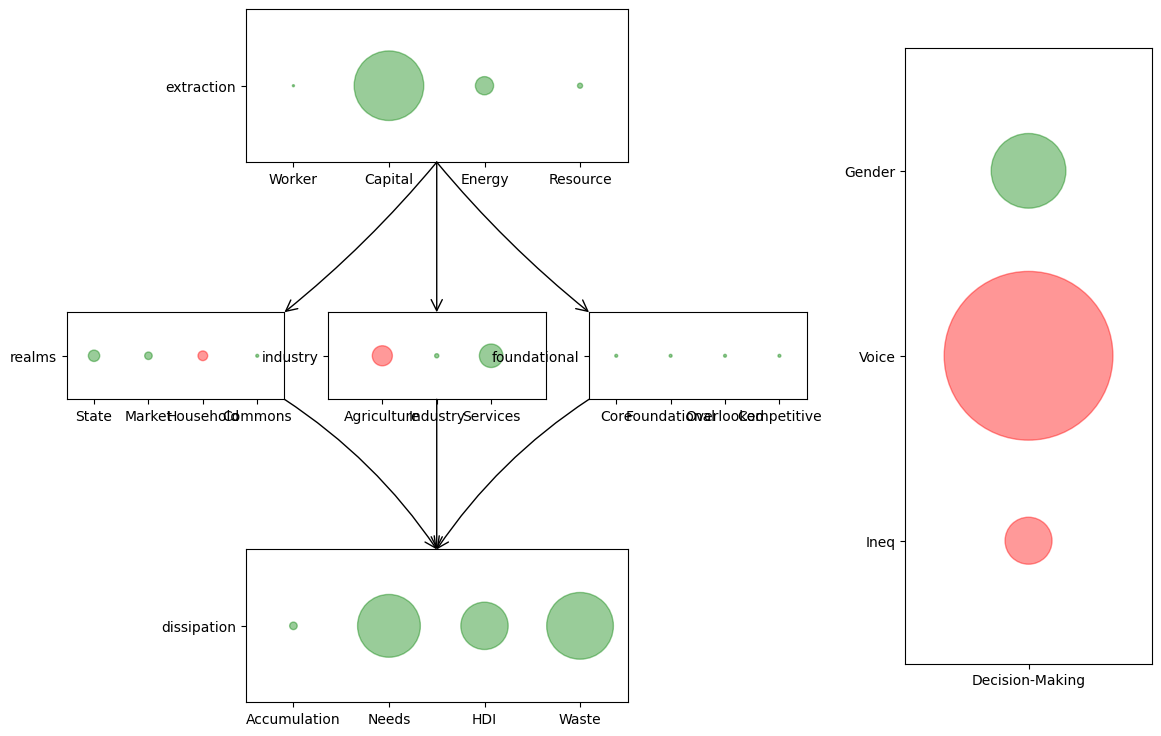

In [418]:
fig, all_axes, ax_side = init_plot()
draw_plot("Canada", 2015, all_axes, ax_side)
plt.show()  # Call plt.show() after setting up the plot

## Try with Plotly

In [419]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


def calculate_circle_properties(size):
    color = 'red' if size < 0 else 'green'
    if size is None or np.isnan(size):
        color = 'grey'
        alpha = 0.2
        radius = 0.02
    else:
        alpha = min(max(abs(size) / 5, 0.4), 1.0)
        radius = abs(size) / 15
    return color, alpha, radius


def determine_plotly_row_col(ax_index):
    if ax_index == 0:
        return 1, 2  # First subplot in the first column
    elif 1 <= ax_index <= 3:
        return 2, ax_index  # Second row, columns 1, 2, and 3 of the first column
    elif ax_index == 4:
        return 3, 2  # Third row, first column
    else:
        return 1, 4  # Spanning subplot in the second column


def set_axis_properties(fig, row, col, xcoords, xaxisticks, yaxisticks):
    # Update axes properties only if the subplot exists
    if col == 1 or col == 2 or col == 3:
        fig.update_yaxes(range=[0.3, 0.7], row=row, col=col)
        fig.update_xaxes(tickvals=xcoords, ticktext=xaxisticks, row=row, col=col)
        fig.update_yaxes(tickvals=[0.5], ticktext=yaxisticks, row=row, col=col)


def set_side_axis_properties(fig, row, col, sideycoords, allsideticks):
    # Update side axis properties only for the first row in the second column
    if col == 4 and row == 1:
        fig.update_xaxes(range=[0.3, 0.7], tickvals=[0.5], ticktext=['Decision-Making'], row=row, col=col)
        fig.update_yaxes(tickvals=sideycoords, ticktext=allsideticks, row=row, col=col)

In [420]:
def draw_plot(country, year_number, fig):
    data_values = get_data_by_year(country, year_number)
    if not data_values:
        print("No data available for the specified country and year.")
        return

    # Unpacking the data
    (agriculture, industry, services, grosscapital, unemployed, wealth, gini, voice,
     femaleminister, lifeexpectancy, education, govconsum, marketcap, houseconsum,
     energy, mfootprint) = data_values

    all_sizes = [[unemployed, wealth, energy, 0.1], [govconsum, marketcap, houseconsum, 0.1],
                 [agriculture, industry, services],
                 [0.1, 0.1, 0.1, 0.1],
                 [grosscapital, lifeexpectancy, education, mfootprint]]
    side_sizes = [gini, voice, femaleminister]

    # Scaling factor for circle sizes
    scaling_factor = 350

    # Draw circles in main axes
    for ax_index, sizes in enumerate(all_sizes):
        row, col = determine_plotly_row_col(ax_index)
        for x, size in zip(all_x_coords[ax_index], sizes):
            color, alpha, radius = calculate_circle_properties(size)
            fig.add_trace(
                go.Scatter(
                    x=[x], y=[0.5], mode='markers',
                    marker=dict(color=color, size=radius * scaling_factor, opacity=alpha),
                ),
                row=row, col=col
            )
        # Set axis properties
        if col != 4:  # Check if it's not the side axis
            set_axis_properties(fig, row, col, all_x_coords[ax_index], all_x_axis_ticks[ax_index],
                                all_y_axis_ticks[ax_index])

    # Draw circles in side axis
    for y, size in zip(side_y_coords, side_sizes):
        color, alpha, radius = calculate_circle_properties(size)
        fig.add_trace(
            go.Scatter(
                x=[0.5],  # Constant x-coordinate for all circles in the side plot
                y=[y],  # Variable y-coordinate from side_y_coords
                mode='markers',
                marker=dict(color=color, size=radius * scaling_factor, opacity=alpha),
            ),
            row=1, col=4  # Spanning subplot in the fourth column
        )

    # Set side axis properties
    set_side_axis_properties(fig, 1, 4, side_y_coords,
                             all_side_ticks)  # Corrected for the spanning subplot in the second column

    return fig


fig = make_subplots(
    rows=3, cols=4,
    column_widths=[0.25, 0.25, 0.25, 0.1],  # Adjust these widths as needed
    specs=[
        [None, {"type": "scatter"}, None, {"type": "scatter", "rowspan": 3}],
        [{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}, None],
        [None, {"type": "scatter"}, None, None]
    ],
    horizontal_spacing=0.02  # Adjust spacing between columns if needed
)

fig.add_annotation(
    dict(
        xref='paper',  # Position reference relative to the whole figure
        yref='paper',
        x=0.05,  # Adjust the position as needed
        y=0.95,  # Adjust the position as needed
        text='Year: 2010',  # Initial year
        showarrow=False,
        font=dict(size=20)  # Adjust font size as needed
    )
)

country_to_plot = 'Canada'  # Change to the country you want to plot

# Initialize the figure with the data for the first year
draw_plot(country_to_plot, 2010, fig)

# Create frames for each year from 2011 to 2015
frames = []
for year in range(2011, 2016):
    # Clear the existing data from the figure
    temp_fig = make_subplots(
        rows=3, cols=4,
        column_widths=[0.25, 0.25, 0.25, 0.1],  # Adjust these widths as needed
        specs=[
            [None, {"type": "scatter"}, None, {"type": "scatter", "rowspan": 3}],
            [{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}, None],
            [None, {"type": "scatter"}, None, None]
        ],
        horizontal_spacing=0.02  # Adjust spacing between columns if needed
    )

    # Update temp_fig with the new data for the current year
    draw_plot(country_to_plot, year, temp_fig)

    # Create a new frame with the updated figure data
    frame = go.Frame(
        data=temp_fig.data,
        name=str(year),
        layout=dict(
            annotations=[
                dict(
                    xref='paper',
                    yref='paper',
                    x=0.05,  # Same position as initial annotation
                    y=0.95,  # Same position as initial annotation
                    text=f'Year: {year}',  # Update text with current year
                    showarrow=False,
                    font=dict(size=20)
                )
            ]
        )
    )
    frames.append(frame)

# Add frames to the figure
fig.frames = frames

# Add play and pause button
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            showactive=False,
            buttons=[
                dict(label="Play", method="animate", args=[None, {"frame": {"duration": 1000}}]),
                dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}}])
            ]
        )
    ]
)

# Show the figure
fig.update_layout(showlegend=False)
fig.show()

In [421]:
fig.print_grid()

This is the format of your plot grid:
    (empty)      [ (1,2) x,y   ]      (empty)      ⎡ (1,4) x2,y2 ⎤
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]  [ (2,3) x5,y5 ]  ⎢      :      ⎟
    (empty)      [ (3,2) x6,y6 ]      (empty)      ⎣      :      ⎦
